In [1]:
import sys
import torch.nn as nn
import torch.nn.functional as F
sys.path.append("../scripts")
from gen_torch_datasets import (
    gen_dataloaders, to_cuda, 
    plot_metrics, plot_confusion_matrix
)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/site-packages/t

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/site-packages/t

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/henrik/miniconda3/envs/hackathon_cph25/lib/python3.10/site-packages/t

AttributeError: _ARRAY_API not found

In [2]:
train_loader, val_loader, input_shape, num_classes = gen_dataloaders(
    "/home/henrik/Documents/EDTH/CPH2025/drone_acoustics_train_val_data",
    1, 
    # 144
    48
)

Train samples: 540
Train labels 540
Val samples: 180
Val labels 180


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class SpectrogramResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, dropout=0.3, reduction=16):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.layer1 = SpectrogramResNetBlock(32, 64, downsample=True, dropout=0.2)
        self.layer2 = SpectrogramResNetBlock(64, 64, downsample=True, dropout=0.3)
        # self.layer3 = SpectrogramResNetBlock(128, 256, downsample=True, dropout=0.4)
        # self.layer4 = SpectrogramResNetBlock(256, 256, downsample=False, dropout=0.4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1)
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [4]:
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


model = SpectrogramResNet(num_classes=num_classes)
model, device = to_cuda(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
metrics = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# Training loop
for epoch in tqdm(range(100)):
    model.train()
    correct = 0
    total = 0
    acc = 0
    for X, y in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
        acc = correct / total
        optimizer.step()
    metrics["train_loss"].append(loss.item())
    metrics["train_acc"].append(acc)

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    acc = correct / total
    metrics["val_acc"].append(acc)


Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU


100%|██████████| 100/100 [10:21<00:00,  6.22s/it]


Max Acc: 0.6833333333333333


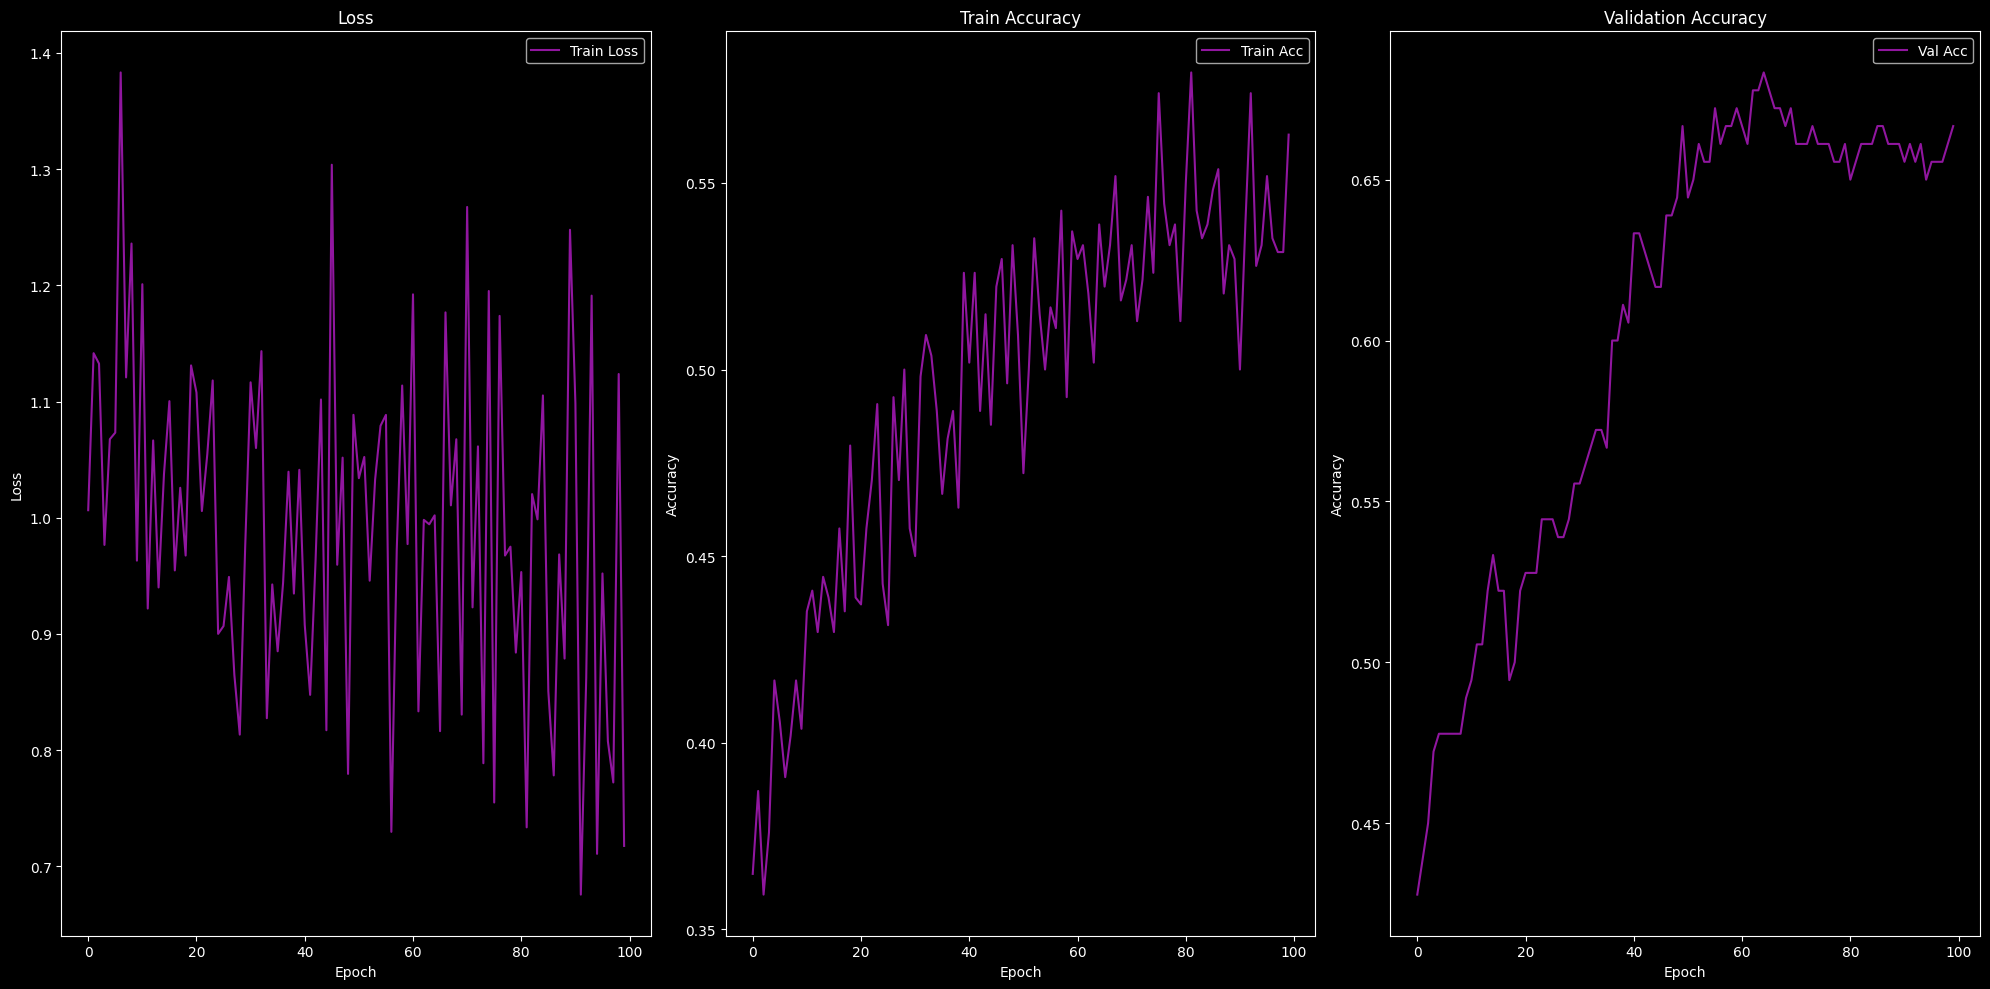

In [5]:
plot_metrics(metrics)

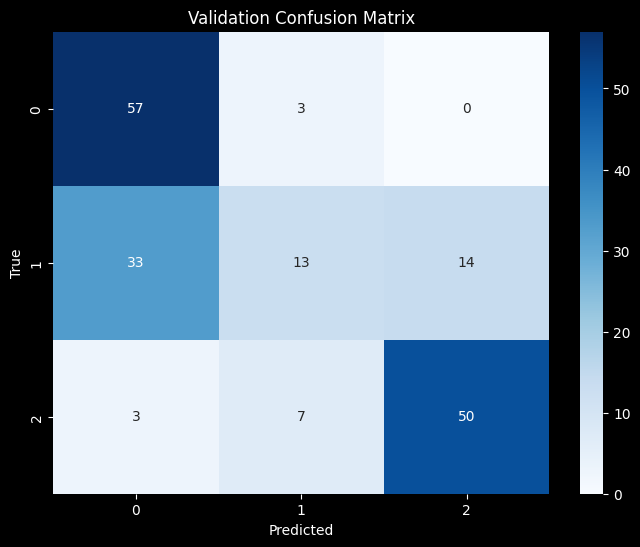

In [6]:
plot_confusion_matrix(model, device, num_classes, val_loader)